In [1]:
# Credit Card Fraud Detection - Model Training
# CodSoft ML Internship - Task 2
# Author: Chandan Kumar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, precision_score, recall_score, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("CREDIT CARD FRAUD DETECTION - MODEL TRAINING")
print("="*70)

CREDIT CARD FRAUD DETECTION - MODEL TRAINING


In [2]:
# 1. LOAD DATA

print("\n📂 Loading datasets...")
df = pd.read_csv('../data/creditcard_scaled.csv')
print("   Dataset loaded successfully.")
print(f"   Shape: {df.shape}")


📂 Loading datasets...
   Dataset loaded successfully.
   Shape: (1852394, 24)


In [3]:
# 2. FEATURE SELECTION (CRITICAL FIX)

TARGET_COL = "is_fraud"

FEATURE_COLS = [
    "amt",
    "lat", "long",
    "city_pop",
    "unix_time",
    "merch_lat", "merch_long"
]

X = df[FEATURE_COLS].copy()
y = df[TARGET_COL].copy()

print("\n📊 Feature Selection")
print(f"Features used: {FEATURE_COLS}")
print(f"Fraud cases: {y.sum():,} ({y.mean()*100:.4f}%)")


📊 Feature Selection
Features used: ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long']
Fraud cases: 9,651 (0.5210%)


In [4]:
# 3. TRAIN–TEST SPLIT (PROVIDED SPLIT)

train_size = int(0.8 * len(df))

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]

print("\n Train–Test Split")
print(f"Train samples: {len(X_train):,}")
print(f"Test samples : {len(X_test):,}")


 Train–Test Split
Train samples: 1,481,915
Test samples : 370,479


In [5]:
# 4. HANDLE CLASS IMBALANCE (SMOTE)

print("\n" + "=" * 70)
print("HANDLING CLASS IMBALANCE WITH SMOTE")
print("=" * 70)

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train, y_train
)

print("✅ SMOTE applied")
print(f"Before: {y_train.sum():,} frauds")
print(f"After : {y_train_balanced.sum():,} frauds")


HANDLING CLASS IMBALANCE WITH SMOTE


✅ SMOTE applied
Before: 8,302 frauds
After : 1,473,613 frauds


In [6]:
# 5. MODEL TRAINING - BASELINE

print("\n" + "=" * 70)
print("PHASE 1: BASELINE MODELS")
print("=" * 70)

results = {}

def train_evaluate_model(model, name, X_tr, y_tr, X_te, y_te):
    print(f"\n🔄 Training {name}...")

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
        roc_auc = roc_auc_score(y_te, y_prob)
    else:
        roc_auc = None

    metrics = {
        "accuracy": accuracy_score(y_te, y_pred),
        "precision": precision_score(y_te, y_pred, zero_division=0),
        "recall": recall_score(y_te, y_pred, zero_division=0),
        "f1": f1_score(y_te, y_pred, zero_division=0),
        "roc_auc": roc_auc
    }

    for k, v in metrics.items():
        if v is not None:
            print(f"   {k.upper():10}: {v:.4f}")

    return {
        "model": model,
        **metrics
    }

# Baseline Models
results["Logistic Regression (Baseline)"] = train_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    "Logistic Regression",
    X_train_balanced, y_train_balanced,
    X_test, y_test
)

results["Decision Tree (Baseline)"] = train_evaluate_model(
    DecisionTreeClassifier(random_state=42),
    "Decision Tree",
    X_train_balanced, y_train_balanced,
    X_test, y_test
)

results["Random Forest (Baseline)"] = train_evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=2),
    "Random Forest",
    X_train_balanced, y_train_balanced,
    X_test, y_test
)


PHASE 1: BASELINE MODELS

🔄 Training Logistic Regression...
   ACCURACY  : 0.0036
   PRECISION : 0.0036
   RECALL    : 1.0000
   F1        : 0.0073
   ROC_AUC   : 0.5164

🔄 Training Decision Tree...
   ACCURACY  : 0.9569
   PRECISION : 0.0195
   RECALL    : 0.2194
   F1        : 0.0358
   ROC_AUC   : 0.5895

🔄 Training Random Forest...
   ACCURACY  : 0.9939
   PRECISION : 0.0648
   RECALL    : 0.0511
   F1        : 0.0572
   ROC_AUC   : 0.8318


In [7]:
# 6. HYPERPARAMETER TUNING (LOGISTIC REGRESSION)

print("\n" + "=" * 70)
print("PHASE 2: HYPERPARAMETER TUNING")
print("=" * 70)

lr_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear"],
    "class_weight": [None, "balanced"]
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    lr_param_grid,
    cv=3,
    scoring="f1",
    n_jobs=2,
    verbose=1
)

lr_grid.fit(X_train_balanced, y_train_balanced)

print("\n✅ Best Parameters:", lr_grid.best_params_)
print(f"✅ Best CV F1: {lr_grid.best_score_:.4f}")


PHASE 2: HYPERPARAMETER TUNING
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best Parameters: {'C': 0.01, 'class_weight': None, 'solver': 'liblinear'}
✅ Best CV F1: 0.7615


In [8]:
results["Logistic Regression (Tuned)"] = train_evaluate_model(
    lr_grid.best_estimator_,
    "Logistic Regression (Tuned)",
    X_train_balanced, y_train_balanced,
    X_test, y_test
)


🔄 Training Logistic Regression (Tuned)...
   ACCURACY  : 0.9628
   PRECISION : 0.0710
   RECALL    : 0.7620
   F1        : 0.1299
   ROC_AUC   : 0.8333


In [9]:
# Decision Tree Tuning
print("\n🔍 Tuning Decision Tree...")
dt_param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [5, 10, 20],
    'class_weight': ['balanced', None]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=3,
    scoring='f1',
    n_jobs=2,
    verbose=1
) 

dt_grid.fit(X_train_balanced, y_train_balanced)
print(f"✅ Best params: {dt_grid.best_params_}")
print(f"✅ Best CV F1: {dt_grid.best_score_:.4f}")


🔍 Tuning Decision Tree...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
✅ Best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10}
✅ Best CV F1: 0.6699


In [10]:
results['Decision Tree (Tuned)'] = train_evaluate_model(
    dt_grid.best_estimator_,
    "Decision Tree (Tuned)",
    X_train_balanced, y_train_balanced, X_test, y_test
)
results['Decision Tree (Tuned)']['best_params'] = dt_grid.best_params_


🔄 Training Decision Tree (Tuned)...
   ACCURACY  : 0.9239
   PRECISION : 0.0355
   RECALL    : 0.7613
   F1        : 0.0679
   ROC_AUC   : 0.9376


In [11]:
# Random Forest Tuning

print("\n🔍 Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [50],          # keep low to reduce memory
    'max_depth': [10],             # limit tree depth
    'min_samples_split': [20],     # reduce overfitting & memory
    'min_samples_leaf': [10],      # VERY important for large data
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=1,          
    bootstrap=True
)

# 🔹 GridSearch with low CV folds
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=2,             
    scoring='f1',
    n_jobs=1,        
    verbose=1
)

# 🔹 Fit on SMOTE-balanced data
rf_grid.fit(X_train_balanced, y_train_balanced)

print(f"✅ Best params: {rf_grid.best_params_}")
print(f"✅ Best CV F1 Score: {rf_grid.best_score_:.4f}")



🔍 Tuning Random Forest...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
✅ Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 50}
✅ Best CV F1 Score: 0.6110


In [12]:
results['Random Forest (Tuned)'] = train_evaluate_model(
    rf_grid.best_estimator_,
    "Random Forest (Tuned)",
    X_train_balanced, y_train_balanced, X_test, y_test
)
results['Random Forest (Tuned)']['best_params'] = rf_grid.best_params_


🔄 Training Random Forest (Tuned)...
   ACCURACY  : 0.9732
   PRECISION : 0.0889
   RECALL    : 0.6894
   F1        : 0.1575
   ROC_AUC   : 0.9083


In [16]:
# 6. MODEL COMPARISON & SELECTION

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_data = []

# Collect metrics of tuned models
for name, metrics in results.items():
    if 'Tuned' in name:
        comparison_data.append({
            'Model': name.replace(' (Tuned)', ''),
            'Accuracy': metrics.get('accuracy'),
            'Precision': metrics.get('precision'),
            'Recall': metrics.get('recall'),
            'F1-Score': metrics.get('f1_score', metrics.get('f1')),
            'ROC-AUC': metrics.get('roc_auc')
        })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Tuned Models Performance:")
print(comparison_df.to_string(index=False))


MODEL COMPARISON

📊 Tuned Models Performance:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.962813   0.070975 0.762046  0.129855 0.833298
      Decision Tree  0.923858   0.035519 0.761305  0.067872 0.937582
      Random Forest  0.973154   0.088936 0.689400  0.157547 0.908343


In [13]:
# 6. MODEL COMPARISON & SELECTION

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_data = []

for name, metrics in results.items():
    if 'Tuned' in name:
        comparison_data.append({
            'Model': name.replace(' (Tuned)', ''),
            'Accuracy': metrics.get('accuracy'),
            'Precision': metrics.get('precision'),
            'Recall': metrics.get('recall'),
            'F1-Score': metrics.get('f1_score', metrics.get('f1')),
            'ROC-AUC': metrics.get('roc_auc')
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Tuned Models Performance:")
print(comparison_df.to_string(index=False))


MODEL COMPARISON

📊 Tuned Models Performance:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.962813   0.070975 0.762046  0.129855 0.833298
      Decision Tree  0.923858   0.035519 0.761305  0.067872 0.937582
      Random Forest  0.973154   0.088936 0.689400  0.157547 0.908343


In [17]:
# Select BEST model based on F1-Score

best_model_name = max(
    [name for name in results.keys() if 'Tuned' in name],
    key=lambda x: results[x].get('f1_score', results[x].get('f1', 0))
)

best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print("\n🏆 BEST MODEL SELECTED")
print(f"   Model Name : {best_model_name}")
print(f"   Precision  : {best_metrics['precision']:.4f}")
print(f"   Recall     : {best_metrics['recall']:.4f}")
print(f"   F1-Score   : {best_metrics.get('f1_score', best_metrics.get('f1')):.4f}")
print(f"   ROC-AUC    : {best_metrics['roc_auc']:.4f}")


🏆 BEST MODEL SELECTED
   Model Name : Random Forest (Tuned)
   Precision  : 0.0889
   Recall     : 0.6894
   F1-Score   : 0.1575
   ROC-AUC    : 0.9083


In [19]:
# 7. SAVE BEST MODEL

print("\n💾 Saving best model...")
joblib.dump(best_model, '../models/fraud_detection_model.pkl')
print("✅ Model saved: ../models/fraud_detection_model.pkl")

# Save all models
for name, result in results.items():
    if 'Tuned' in name:
        filename = f"../models/{name.lower().replace(' ', '_').replace('(tuned)', 'model')}.pkl"
        joblib.dump(result['model'], filename)
        print(f"✅ Saved: {filename}")


💾 Saving best model...
✅ Model saved: ../models/fraud_detection_model.pkl
✅ Saved: ../models/logistic_regression_model.pkl
✅ Saved: ../models/decision_tree_model.pkl
✅ Saved: ../models/random_forest_model.pkl



DETAILED EVALUATION OF THE BEST MODEL

Best Model: Random Forest (Tuned)

📄 Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9988    0.9742    0.9864    369130
  Fraudulent     0.0889    0.6894    0.1575      1349

    accuracy                         0.9732    370479
   macro avg     0.5439    0.8318    0.5720    370479
weighted avg     0.9955    0.9732    0.9833    370479



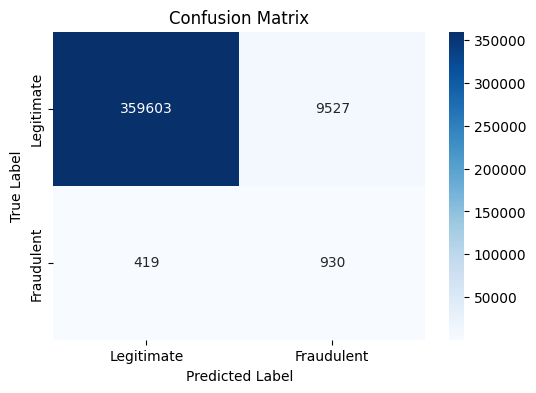

Specificity: 0.9742


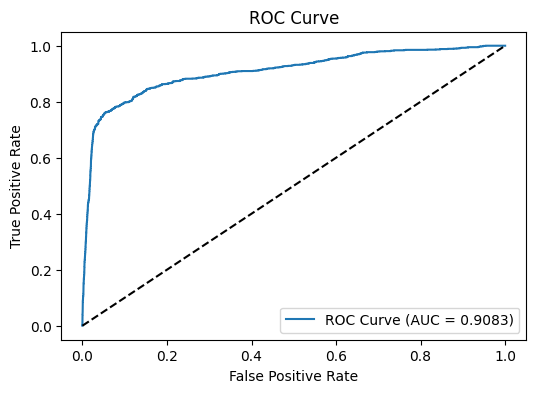

In [20]:
# 8. DETAILED EVALUATION

print("\n" + "="*70)
print("DETAILED EVALUATION OF THE BEST MODEL")
best_model_name = max(
    results.items(),
    key=lambda x: x[1]['f1']
)[0]
best_model = results[best_model_name]['model']
y_pred = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:, 1]
else:
    y_prob = None
print(f"\nBest Model: {best_model_name}")

# Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent'], digits=4))

# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix')   
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('../images/confusion_matrix.png')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print(f"Specificity: {specificity:.4f}")
if y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig('../images/roc_curve.png')
    plt.show()


📊 Generating Visualizations...


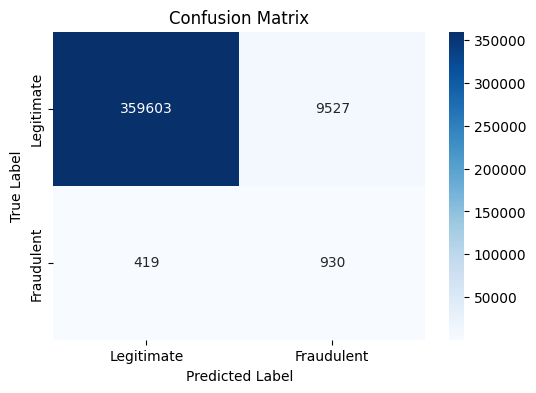

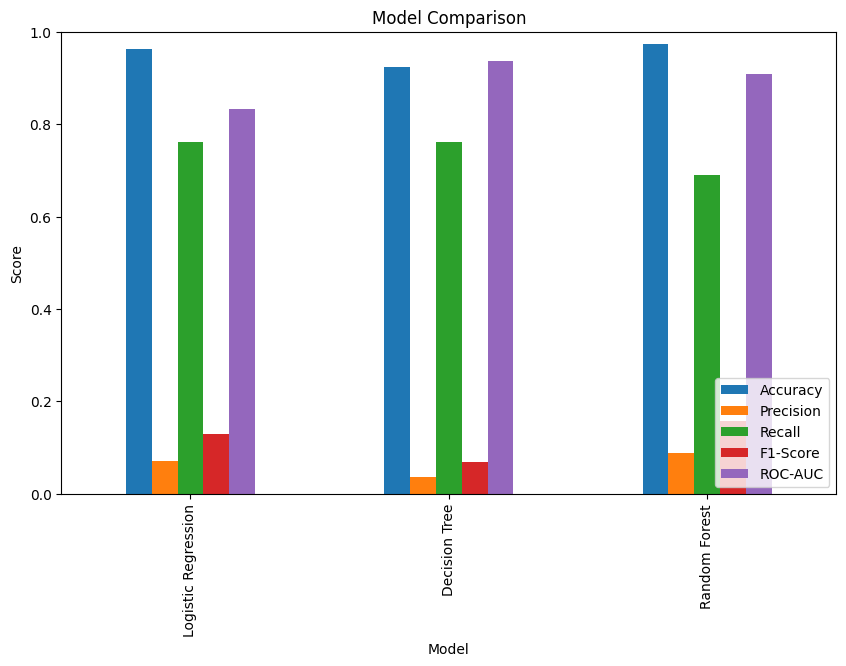

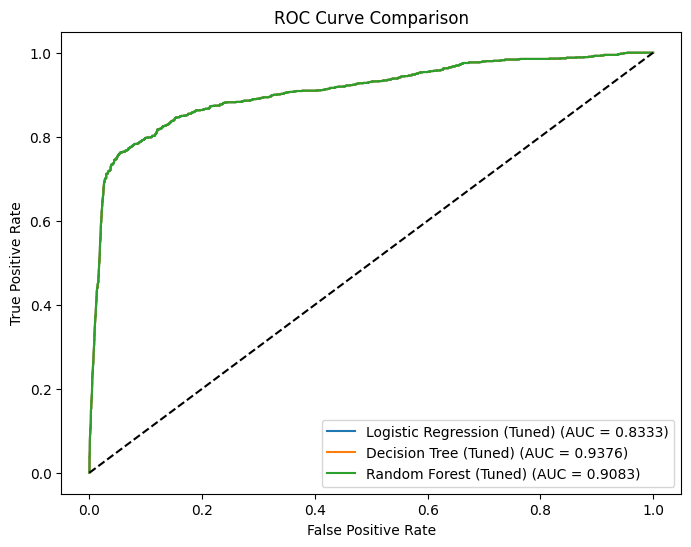

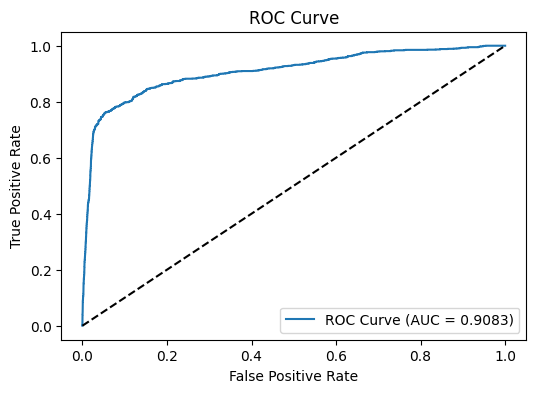

✅ Visualizations saved in ../images/


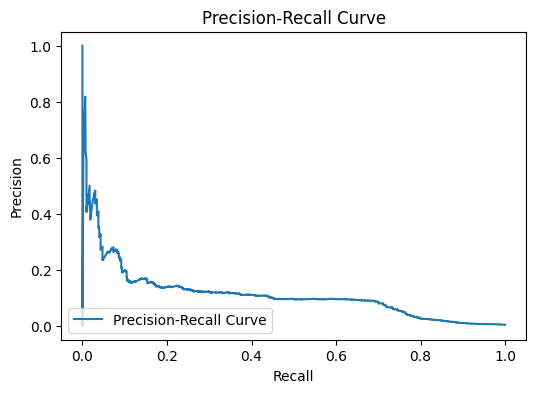

✅ Visualizations saved in ../images/


In [21]:
# 9. VISUALIZATIONS

print("\n📊 Generating Visualizations...")

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))      
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('../images/confusion_matrix.png')
plt.show()

# 2. Model Comparison
comparison_df.set_index('Model').plot.bar(figsize=(10, 6))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.savefig('../images/model_comparison.png')
plt.show()

# ROC-AUC comparison
plt.figure(figsize=(8, 6))
for name, metrics in results.items():
    if 'Tuned' in name and metrics.get('roc_auc') is not None:
        fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["roc_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('../images/roc_curve_comparison.png')
plt.show()

# 3. ROC Curve
if y_prob is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.savefig('../images/roc_curve.png')
    plt.show()
print("✅ Visualizations saved in ../images/")

# 4. Precision-Recall Curve
if y_prob is not None:
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.savefig('../images/precision_recall_curve.png')
    plt.show()
print("✅ Visualizations saved in ../images/")

In [22]:
# 10. SAVE METRICS
print("\n💾 Saving metrics...")

# prepare results for JSON
json_results = {}
for name, metrics in results.items():
    json_results[name] = {k: (v if not isinstance(v, np.float64) else float(v)) for k, v in metrics.items() if k != 'model'}
with open('../artifacts/model_performance.json', 'w') as f:
    json.dump(json_results, f, indent=4)
print("✅ Metrics saved: ../artifacts/model_performance.json")


# Save classification report
report = classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent'], digits=4, output_dict=True)
with open('../artifacts/classification_report.json', 'w') as f:
    json.dump(report, f, indent=4)
print("✅ Classification report saved: ../artifacts/classification_report.json")



💾 Saving metrics...
✅ Metrics saved: ../artifacts/model_performance.json
✅ Classification report saved: ../artifacts/classification_report.json
